In [1]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline


# Reinforcement Learning (DQN) Tutorial
**Author**: [Adam Paszke](https://github.com/apaszke)
            [Mark Towers](https://github.com/pseudo-rnd-thoughts)


This tutorial shows how to use PyTorch to train a Deep Q Learning (DQN) agent
on the CartPole-v1 task from [Gymnasium](https://gymnasium.farama.org)_.

**Task**

The agent has to decide between two actions - moving the cart left or
right - so that the pole attached to it stays upright. You can find more
information about the environment and other more challenging environments at
[Gymnasium's website](https://gymnasium.farama.org/environments/classic_control/cart_pole/)_.

.. figure:: /_static/img/cartpole.gif
   :alt: CartPole

   CartPole

As the agent observes the current state of the environment and chooses
an action, the environment *transitions* to a new state, and also
returns a reward that indicates the consequences of the action. In this
task, rewards are +1 for every incremental timestep and the environment
terminates if the pole falls over too far or the cart moves more than 2.4
units away from center. This means better performing scenarios will run
for longer duration, accumulating larger return.

The CartPole task is designed so that the inputs to the agent are 4 real
values representing the environment state (position, velocity, etc.).
We take these 4 inputs without any scaling and pass them through a
small fully-connected network with 2 outputs, one for each action.
The network is trained to predict the expected value for each action,
given the input state. The action with the highest expected value is
then chosen.


**Packages**


First, let's import needed packages. Firstly, we need
[gymnasium](https://gymnasium.farama.org/)_ for the environment,
installed by using `pip`. This is a fork of the original OpenAI
Gym project and maintained by the same team since Gym v0.19.
If you are running this in Google Colab, run:


In [2]:
# %%bash
# pip3 install gymnasium[classic_control]

We'll also use the following from PyTorch:

-  neural networks (``torch.nn``)
-  optimization (``torch.optim``)
-  automatic differentiation (``torch.autograd``)


In [3]:
import gymnasium as gym
import DREnv_fake
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Custom Env

In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

import gymnasium as gym
from gymnasium import spaces

class DREnv(gym.Env):
    # draw bar chart and line curve for visuliazation
    # metadata = ("render_modes": [])

    def __init__(self, actions, window_size=2, render_mode=None, drcmax=1e6, input_size=9):
        self.size = drcmax
        self.maxdrc = None
        self.window_size = window_size
        self.input_size = input_size
        self._index = -1
        if actions is None:
            # index: (size, offset, mazeEndIter, DRCCost, MarkerCost, FixedShapeCost, Decay, ripupMode, followGuide)
            # We have 65 actions, corresponding to default DRC sequences
            # shapeCost = 8
            # MARKERCOST = 32
            # ripupMode: ALL->0, DRC->0.5, NEARDRC->1
            # followGuide: True->1, False->0
            actions = [[7,  0,  3,      8,       0,       8, 0.950, 0    ,  1],
                        [7, -2,  3,      8,       8,       8, 0.950, 0    ,  1],
                        [7, -5,  3,      8,       8,       8, 0.950, 0    ,  1],
                        [7,  0,  8,      8,      32,   2 * 8, 0.950, 0.5    , 0],
                        [7, -1,  8,      8,      32,   2 * 8, 0.950, 0.5    , 0],
                        [7, -2,  8,      8,      32,   2 * 8, 0.950, 0.5    , 0],
                        [7, -3,  8,      8,      32,   2 * 8, 0.950, 0.5    , 0],
                        [7, -4,  8,      8,      32,   2 * 8, 0.950, 0.5    , 0],
                        [7, -5,  8,      8,      32,   2 * 8, 0.950, 0.5    , 0],
                        [7, -6,  8,      8,      32,   2 * 8, 0.950, 0.5    , 0],
                        [7,  0,  8,  2 * 8,      32,   3 * 8, 0.950, 0.5    , 0],
                        [7, -1,  8,  2 * 8,      32,   3 * 8, 0.950, 0.5    , 0],
                        [7, -2,  8,  2 * 8,      32,   3 * 8, 0.950, 0.5    , 0],
                        [7, -3,  8,  2 * 8,      32,   3 * 8, 0.950, 0.5    , 0],
                        [7, -4,  8,  2 * 8,      32,   3 * 8, 0.950, 0.5    , 0],
                        [7, -5,  8,  2 * 8,      32,   4 * 8, 0.950, 0.5    , 0],
                        [7, -6,  8,  2 * 8,      32,   4 * 8, 0.950, 0.5    , 0],
                        [7, -3,  8,      8,      32,   4 * 8, 0.950, 0    , 0],
                        [7,  0,  8,  4 * 8,      32,   4 * 8, 0.950, 0.5    , 0],
                        [7, -1,  8,  4 * 8,      32,   4 * 8, 0.950, 0.5    , 0],
                        [7, -2,  8,  4 * 8,      32,  10 * 8, 0.950, 0.5    , 0],
                        [7, -3,  8,  4 * 8,      32,  10 * 8, 0.950, 0.5    , 0],
                        [7, -4,  8,  4 * 8,      32,  10 * 8, 0.950, 0.5    , 0],
                        [7, -5,  8,      8,      32,  10 * 8, 0.950, 1, 0],
                        [7, -6,  8,  4 * 8,      32,  10 * 8, 0.950, 0.5    , 0],
                        [5, -2,  8,      8,      32,  10 * 8, 0.950, 0    , 0],
                        [7,  0,  8,  8 * 8,  2 * 32,  10 * 8, 0.950, 0.5    , 0],
                        [7, -1,  8,  8 * 8,  2 * 32,  10 * 8, 0.950, 0.5    , 0],
                        [7, -2,  8,  8 * 8,  2 * 32,  10 * 8, 0.950, 0.5    , 0],
                        [7, -3,  8,  8 * 8,  2 * 32,  10 * 8, 0.950, 0.5    , 0],
                        [7, -4,  8,      8,      32,  50 * 8, 0.950, 1, 0],
                        [7, -5,  8,  8 * 8,  2 * 32,  50 * 8, 0.950, 0.5    , 0],
                        [7, -6,  8,  8 * 8,  2 * 32,  50 * 8, 0.950, 0.5    , 0],
                        [3, -1,  8,      8,      32,  50 * 8, 0.950, 0    , 0],
                        [7,  0,  8, 16 * 8,  4 * 32,  50 * 8, 0.950, 0.5    , 0],
                        [7, -1,  8, 16 * 8,  4 * 32,  50 * 8, 0.950, 0.5    , 0],
                        [7, -2,  8, 16 * 8,  4 * 32,  50 * 8, 0.950, 0.5    , 0],
                        [7, -3,  8,      8,      32,  50 * 8, 0.950, 1, 0],
                        [7, -4,  8, 16 * 8,  4 * 32,  50 * 8, 0.950, 0.5    , 0],
                        [7, -5,  8, 16 * 8,  4 * 32,  50 * 8, 0.950, 0.5    , 0],
                        [7, -6,  8, 16 * 8,  4 * 32, 100 * 8, 0.990, 0.5    , 0],
                        [3, -2,  8,      8,      32, 100 * 8, 0.990, 0    , 0],
                        [7,  0, 16, 16 * 8,  4 * 32, 100 * 8, 0.990, 0.5    , 0],
                        [7, -1, 16, 16 * 8,  4 * 32, 100 * 8, 0.990, 0.5    , 0],
                        [7, -2, 16,      8,      32, 100 * 8, 0.990, 1, 0],
                        [7, -3, 16, 16 * 8,  4 * 32, 100 * 8, 0.990, 0.5    , 0],
                        [7, -4, 16, 16 * 8,  4 * 32, 100 * 8, 0.990, 0.5    , 0],
                        [7, -5, 16, 16 * 8,  4 * 32, 100 * 8, 0.990, 0.5    , 0],
                        [7, -6, 16, 16 * 8,  4 * 32, 100 * 8, 0.990, 0.5    , 0],
                        [3, -0,  8,      8,      32, 100 * 8, 0.990, 0    , 0],
                        [7,  0, 32, 32 * 8,  8 * 32, 100 * 8, 0.999, 0.5    , 0],
                        [7, -1, 32,      8,      32, 100 * 8, 0.999, 1, 0],
                        [7, -2, 32, 32 * 8,  8 * 32, 100 * 8, 0.999, 0.5    , 0],
                        [7, -3, 32, 32 * 8,  8 * 32, 100 * 8, 0.999, 0.5    , 0],
                        [7, -4, 32, 32 * 8,  8 * 32, 100 * 8, 0.999, 0.5    , 0],
                        [7, -5, 32, 32 * 8,  8 * 32, 100 * 8, 0.999, 0.5    , 0],
                        [7, -6, 32, 32 * 8,  8 * 32, 100 * 8, 0.999, 0.5    , 0],
                        [3, -1,  8,      8,      32, 100 * 8, 0.999, 0    , 0],
                        [7,  0, 64,      8,      32, 100 * 8, 0.999, 1, 0],
                        [7, -1, 64, 64 * 8, 16 * 32, 100 * 8, 0.999, 0.5    , 0],
                        [7, -2, 64, 64 * 8, 16 * 32, 100 * 8, 0.999, 0.5    , 0],
                        [7, -3, 64, 64 * 8, 16 * 32, 100 * 8, 0.999, 0.5    , 0],
                        [7, -4, 64, 64 * 8, 16 * 32, 100 * 8, 0.999, 0.5    , 0],
                        [7, -5, 64, 64 * 8, 16 * 32, 100 * 8, 0.999, 0.5    , 0],
                        [7, -6, 64, 64 * 8, 16 * 32, 100 * 8, 0.999, 0.5    , 0]]
        columns = ['size', 'offset', 'mazeEndIter', 'DRCCost', 'MarkerCost', 'FixedShapeCost', 'Decay', 'ripupMode', 'followGuide']
        self.actions = pd.DataFrame(actions, columns=columns)
        self.action_space = spaces.Discrete(self.actions.shape[0])
        # Observations are boxes containing the historical DRC sequence settings and DRC values
        self.observations = None
        self.observation_space = spaces.Box(low=-1, high=1, shape=(self.window_size, self.input_size), dtype=float)

    def _preprocessing(self):
        if 'size' in self.actions.columns:
            # action space preprocessing
            # drop columns: size
            self.actions = self.actions.drop(columns=['size'])
    
            # normalize coefficients
            for column in ['offset', 'mazeEndIter', 'DRCCost', 'MarkerCost', 'FixedShapeCost', 'Decay']:
                sc = MinMaxScaler(feature_range=(-1, 1))
                self.actions[column] = sc.fit_transform(self.actions[column].to_numpy().reshape(-1, 1))
        
        # observation space preprocessing
        # padding historical data
        self.observations = np.ones((self.window_size, self.input_size), dtype=float) * -1
        # generate drc value before 0th iteration
        self.maxdrc = self.np_random.integers(1, self.size, size=1, dtype=int)[0]
        self.observations[-1, -1] = 1
        # parameters initialization
        self._index = -1
        self._reward = -1   # reward starting value
        self._curr_drc = 1

    def _action_to_setting(self, action):
        """
        The following dictionary maps abstract actions from `self.action_space` to
        the setting we will use for next iteration.
        I.e. 0 corresponds to the 0th default setting
        """
        # return selected value
        return list(self.actions.iloc[action, :])

    def _get_obs(self, action):
        """get DRC value for current iteration"""
        if action:
            # update DRC value
            # randomly generate DRC value for current iteration
            if int(self._curr_drc * self.maxdrc) == 0:
                drc = 0
            else:
                drc = np.array(self.np_random.integers(0, int(self._curr_drc * self.maxdrc), size=1, dtype=int) / self.maxdrc)
            # print(f"self._curr_drc {self._curr_drc}, self.maxdrc {self.maxdrc}")
            self._curr_drc = drc
            # generate observation for current iteration
            setting = self._action_to_setting(action)
            line = np.append(setting, drc)
            # update the whole observation
            self.observations = np.r_[self.observations, [line]]
            self.observations = np.delete(self.observations, 0, 0)
            
        return self.observations

    def _get_info(self):
        """"provide index for current iteration"""
        return {
            "iteration index": self._index
        }

    def reset(self, seed=None, options=None):
        # We need the following line to seed self.np_random
        super().reset(seed=seed)

        self._preprocessing()
        observation = self._get_obs(None)
        info = self._get_info()
    
        # if self.render_mode == "human":
        #     self._render_frame()
    
        return observation, info

    def step(self, action):
        # Map the action (element of {0,1,2,3}) to the setting we use
        reward = self._reward
        
        # update index
        self._index += 1

        # update observation
        observation = self._get_obs(action)

        # update truncated
        if self._index == 64 and self._curr_drc != 0:
            # punish truncated case
            truncated = True
            reward = -255    # -255 is a large value without detailed thought
        else:
            truncated = False

        # An episode is done iff current DRC value goes to zero
        if self._curr_drc:
            terminated = False
        else:
            terminated = True
            # udpate reward: encourage finishing detailed routing using less iterations
            reward = 0

        # update info
        info = self._get_info()
    
        # if self.render_mode == "human":
        #     self._render_frame()
    
        return observation, reward, terminated, truncated, info

In [5]:
# test in notebook
actions = None
window_size = 2
input_size = 9
env = DREnv(actions, window_size=window_size, input_size=input_size)

In [6]:
env.actions

,size,offset,mazeEndIter,DRCCost,MarkerCost,FixedShapeCost,Decay,ripupMode,followGuide
0,7,0,3,8,0,8,0.950,0.0,1
1,7,-2,3,8,8,8,0.950,0.0,1
2,7,-5,3,8,8,8,0.950,0.0,1
3,7,0,8,8,32,16,0.950,0.5,0
4,7,-1,8,8,32,16,0.950,0.5,0
...,...,...,...,...,...,...,...,...,...
60,7,-2,64,512,512,800,0.999,0.5,0
61,7,-3,64,512,512,800,0.999,0.5,0
62,7,-4,64,512,512,800,0.999,0.5,0
63,7,-5,64,512,512,800,0.999,0.5,0


In [7]:
observation, info = env.reset()

In [8]:
observation

array([[-1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1.,  1.]])

In [9]:
info

{'iteration index': -1}

In [10]:
env.actions

,offset,mazeEndIter,DRCCost,MarkerCost,FixedShapeCost,Decay,ripupMode,followGuide
0,1.000000,-1.000000,-1.0,-1.00000,-1.000000,-1.0,0.0,1
1,0.333333,-1.000000,-1.0,-0.96875,-1.000000,-1.0,0.0,1
2,-0.666667,-1.000000,-1.0,-0.96875,-1.000000,-1.0,0.0,1
3,1.000000,-0.836066,-1.0,-0.87500,-0.979798,-1.0,0.5,0
4,0.666667,-0.836066,-1.0,-0.87500,-0.979798,-1.0,0.5,0
...,...,...,...,...,...,...,...,...
60,0.333333,1.000000,1.0,1.00000,1.000000,1.0,0.5,0
61,0.000000,1.000000,1.0,1.00000,1.000000,1.0,0.5,0
62,-0.333333,1.000000,1.0,1.00000,1.000000,1.0,0.5,0
63,-0.666667,1.000000,1.0,1.00000,1.000000,1.0,0.5,0


In [11]:
env.actions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65 entries, 0 to 64
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   offset          65 non-null     float64
 1   mazeEndIter     65 non-null     float64
 2   DRCCost         65 non-null     float64
 3   MarkerCost      65 non-null     float64
 4   FixedShapeCost  65 non-null     float64
 5   Decay           65 non-null     float64
 6   ripupMode       65 non-null     float64
 7   followGuide     65 non-null     int64  
dtypes: float64(7), int64(1)
memory usage: 4.2 KB


In [12]:
env.actions.describe()

,offset,mazeEndIter,DRCCost,MarkerCost,FixedShapeCost,Decay,ripupMode,followGuide
count,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000
mean,0.056410,-0.532913,-0.603907,-0.545192,-0.040559,-0.287284,0.476923,0.046154
std,0.665544,0.593202,0.595453,0.565018,0.886749,0.915474,0.240942,0.211451
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,0.000000
25%,-0.666667,-0.836066,-1.000000,-0.875000,-0.939394,-1.000000,0.500000,0.000000
50%,0.000000,-0.836066,-0.904762,-0.875000,-0.010101,-1.000000,0.500000,0.000000
75%,0.666667,-0.573770,-0.523810,-0.500000,1.000000,0.632653,0.500000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [13]:
# test loop
sample = 100
num = 1
env.reset()

for _ in range(sample):
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    print("Design {} iteration {} DRC: {}, reward: {}, terminated: {}, truncated: {}\nobservation {}".format(num, 
        info['iteration index'], observation[-1, -1], reward, terminated, truncated, observation))
    if terminated or truncated:
        observation, info = env.reset()
        num += 1
env.close()

Design 1 iteration 0 DRC: 0.19460836496035053, reward: -1, terminated: False, truncated: False
observation [[-1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.          1.        ]
 [-1.         -0.83606557 -0.9047619  -0.875      -0.81818182 -1.
   0.5         0.          0.19460836]]
Design 1 iteration 1 DRC: 0.028298466475361782, reward: -1, terminated: False, truncated: False
observation [[-1.         -0.83606557 -0.9047619  -0.875      -0.81818182 -1.
   0.5         0.          0.19460836]
 [ 0.66666667 -0.83606557 -0.96825397 -0.875      -0.95959596 -1.
   0.5         0.          0.02829847]]
Design 1 iteration 2 DRC: 0.024568792619334135, reward: -1, terminated: False, truncated: False
observation [[ 0.66666667 -0.83606557 -0.96825397 -0.875      -0.95959596 -1.
   0.5         0.          0.02829847]
 [-0.33333333 -0.83606557 -0.96825397 -0.875      -0.95959596 -1.
   0.5         0.          0.02456879]]
Design 1 iteration 3 DRC: 0.0134472677342713

/tmp/ipykernel_15530/1370369620.py:133: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if int(self._curr_drc * self.maxdrc) == 0:
/tmp/ipykernel_15530/1370369620.py:136: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  drc = np.array(self.np_random.integers(0, int(self._curr_drc * self.maxdrc), size=1, dtype=int) / self.maxdrc)


## Replay Memory

We'll be using experience replay memory for training our DQN. It stores
the transitions that the agent observes, allowing us to reuse this data
later. By sampling from it randomly, the transitions that build up a
batch are decorrelated. It has been shown that this greatly stabilizes
and improves the DQN training procedure.

For this, we're going to need two classes:

-  ``Transition`` - a named tuple representing a single transition in
   our environment. It essentially maps (state, action) pairs
   to their (next_state, reward) result, with the state being the
   screen difference image as described later on.
-  ``ReplayMemory`` - a cyclic buffer of bounded size that holds the
   transitions observed recently. It also implements a ``.sample()``
   method for selecting a random batch of transitions for training.




In [14]:
# a data structure containing several named elements
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

Now, let's define our model. But first, let's quickly recap what a DQN is.

## DQN algorithm

Our environment is deterministic, so all equations presented here are
also formulated deterministically for the sake of simplicity. In the
reinforcement learning literature, they would also contain expectations
over stochastic transitions in the environment.

Our aim will be to train a policy that tries to maximize the discounted,
cumulative reward
$R_{t_0} = \sum_{t=t_0}^{\infty} \gamma^{t - t_0} r_t$, where
$R_{t_0}$ is also known as the *return*. The discount,
$\gamma$, should be a constant between $0$ and $1$
that ensures the sum converges. A lower $\gamma$ makes
rewards from the uncertain far future less important for our agent
than the ones in the near future that it can be fairly confident
about. It also encourages agents to collect reward closer in time
than equivalent rewards that are temporally far away in the future.

The main idea behind Q-learning is that if we had a function
$Q^*: State \times Action \rightarrow \mathbb{R}$, that could tell
us what our return would be, if we were to take an action in a given
state, then we could easily construct a policy that maximizes our
rewards:

\begin{align}\pi^*(s) = \arg\!\max_a \ Q^*(s, a)\end{align}

However, we don't know everything about the world, so we don't have
access to $Q^*$. But, since neural networks are universal function
approximators, we can simply create one and train it to resemble
$Q^*$.

For our training update rule, we'll use a fact that every $Q$
function for some policy obeys the Bellman equation:

\begin{align}Q^{\pi}(s, a) = r + \gamma Q^{\pi}(s', \pi(s'))\end{align}

The difference between the two sides of the equality is known as the
temporal difference error, $\delta$:

\begin{align}\delta = Q(s, a) - (r + \gamma \max_a' Q(s', a))\end{align}

To minimize this error, we will use the [Huber
loss](https://en.wikipedia.org/wiki/Huber_loss)_. The Huber loss acts
like the mean squared error when the error is small, but like the mean
absolute error when the error is large - this makes it more robust to
outliers when the estimates of $Q$ are very noisy. We calculate
this over a batch of transitions, $B$, sampled from the replay
memory:

\begin{align}\mathcal{L} = \frac{1}{|B|}\sum_{(s, a, s', r) \ \in \ B} \mathcal{L}(\delta)\end{align}

\begin{align}\text{where} \quad \mathcal{L}(\delta) = \begin{cases}
     \frac{1}{2}{\delta^2}  & \text{for } |\delta| \le 1, \\
     |\delta| - \frac{1}{2} & \text{otherwise.}
   \end{cases}\end{align}

### Q-network

Our model will be a feed forward  neural network that takes in the
difference between the current and previous screen patches. It has two
outputs, representing $Q(s, \mathrm{left})$ and
$Q(s, \mathrm{right})$ (where $s$ is the input to the
network). In effect, the network is trying to predict the *expected return* of
taking each action given the current input.

<img src="../docs/img/RLLSTM model structure.jpg">

In [15]:
# Q-network model
# the target is to learn the Q-function, which takes 
#     state/observation X action pairs as input,
#     and make predictions about return (cumulation of rewards) 
#     Q:State x Action -> Return
# inputs:
#     n_observations: number of elements in observations, 
#         which is time series input for current state 
#         with historical data
#     n_actions: number of actions in environment action space
# outputs:
#     model output with dimension n_actions: each represents the 
#         expected return of the state x action pair

# class DQN(nn.Module):

#     def __init__(self, n_observations, n_actions):
#         super(DQN, self).__init__()
#         self.layer1 = nn.Linear(n_observations, 128)
#         self.layer2 = nn.Linear(128, 128)
#         self.layer3 = nn.Linear(128, n_actions)

#     # Called with either one element to determine next action, or a batch
#     # during optimization. Returns tensor([[left0exp,right0exp]...]).
#     def forward(self, x):
#         x = F.relu(self.layer1(x))
#         x = F.relu(self.layer2(x))
#         return self.layer3(x)

# class DQN(nn.Module):
#     def __init__(self,input_size=9, seq_len=2, coeff_size=8, hidden_size=10,
#                  output_size=65, num_layers=10,dropout=0.2):
#         super().__init__()
#         self.hidden_size = hidden_size
#         self.seq_len = seq_len
#         self.coeff_size = coeff_size
#         self.output_size = output_size
        
#         # initializing h0 and c0:
#         self.hidden = (torch.zeros(num_layers, self.hidden_size).to(device),    # h0
#                        torch.zeros(num_layers, self.hidden_size).to(device))    # c0

#         # add an LSTM layer:
#         self.lstm = nn.LSTM(input_size,hidden_size, 
#                             num_layers=num_layers, dropout=dropout)
        
#         # TODO: change fully-connected layer structure
#         # add a fully-connected layer:
#         self.in_features = seq_len * hidden_size + output_size * coeff_size
#         self.linear = nn.Linear(self.in_features, self.output_size)

#     def forward(self, inputs):
#         # TODO: parse inputs
#         seq = inputs[:self.seq_len, :].view(inputs.shape[0] - self.output_size, -1).to(device)
#         coeff = inputs[self.seq_len:, :self.coeff_size].reshape((inputs.shape[0] - self.seq_len) * self.coeff_size).to(device)
        
#         lstm_out, self.hidden = self.lstm(seq, self.hidden)
        
#         data = torch.cat((lstm_out.view(lstm_out.shape[0] * lstm_out.shape[1]), coeff), 0)
        
#         pred = self.linear(data)
        
#         return pred

In [16]:
# a simple CNN
class DQN(nn.Module):

    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()
        
        self.layer1 = nn.Linear(input_size, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, output_size)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = torch.flatten(x)
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        
        return self.layer3(x)

## Training

### Hyperparameters and utilities
This cell instantiates our model and its optimizer, and defines some
utilities:

-  ``select_action`` - will select an action accordingly to an epsilon
   greedy policy. Simply put, we'll sometimes use our model for choosing
   the action, and sometimes we'll just sample one uniformly. The
   probability of choosing a random action will start at ``EPS_START``
   and will decay exponentially towards ``EPS_END``. ``EPS_DECAY``
   controls the rate of the decay.
-  ``plot_durations`` - a helper for plotting the duration of episodes,
   along with an average over the last 100 episodes (the measure used in
   the official evaluations). The plot will be underneath the cell
   containing the main training loop, and will update after every
   episode.




In [17]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 1
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

In [18]:
# # LSTM-based DQN
# # instantiate
# seq_len = len(observation)
# coeff_size = len(env.actions.columns) - 1
# hidden_size = 10         # from LSTM notebook experience
# output_size = n_actions
# num_layers = 10          # from LSTM notebook experience
# dropout = 0.2
# policy_net = DQN(input_size=input_size, seq_len=seq_len, coeff_size=coeff_size, 
#                  hidden_size=hidden_size, output_size=output_size, 
#                  num_layers=num_layers,dropout=dropout).to(device)
# target_net = DQN(input_size=input_size, seq_len=seq_len, coeff_size=coeff_size, 
#                  hidden_size=hidden_size, output_size=output_size, 
#                  num_layers=num_layers,dropout=dropout).to(device)

# ANN-based DQN
# instantiate
seq_len = len(observation)
output_size = n_actions

policy_net = DQN(input_size=input_size * (seq_len + n_actions), output_size=output_size).to(device)
target_net = DQN(input_size=input_size * (seq_len + n_actions), output_size=output_size).to(device)
target_net.load_state_dict(policy_net.state_dict())

<All keys matched successfully>

In [19]:
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
criterion = nn.SmoothL1Loss()
memory = ReplayMemory(1000)

In [20]:
steps_done = 0
# create actions for network input
df_actions = env.actions.copy()
df_actions.loc[:, 'drc'] = np.ones(len(df_actions)) * -1
actions = df_actions.to_numpy()

def select_action(state):
    global steps_done
    global actions
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        # select action according to policy
        with torch.no_grad():
            # t.min(0) will return the smallest drc value of the tensor returned by the policy network.
            # we pick action with the smallest expected DRC value.
            # create network input
            # inputs shape torch.Size([67, 9])
            inputs = np.vstack((state, actions))
            inputs = torch.from_numpy(inputs)
            inputs = inputs.to(device, dtype=torch.float32)
            # select the action with minimum DRC output as optimum action
            return policy_net(inputs).min(0).indices.view(1, 1)
    else:
        # select action randomly from action space
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [21]:
obs, _  = env.reset()
obs

array([[-1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1.,  1.]])

In [22]:
actions.shape

(65, 9)

In [23]:
for i in range(10):
    select_action(obs)

### Training loop

Finally, the code for training our model.

Here, you can find an ``optimize_model`` function that performs a
single step of the optimization. It first samples a batch, concatenates
all the tensors into a single one, computes $Q(s_t, a_t)$ and
$V(s_{t+1}) = \max_a Q(s_{t+1}, a)$, and combines them into our
loss. By definition we set $V(s) = 0$ if $s$ is a terminal
state. We also use a target network to compute $V(s_{t+1})$ for
added stability. The target network is updated at every step with a
[soft update](https://arxiv.org/pdf/1509.02971.pdf)_ controlled by
the hyperparameter ``TAU``, which was previously defined.

In [24]:
# batch version
# def optimize_model():
#     if len(memory) < BATCH_SIZE:
#         return
#     transitions = memory.sample(BATCH_SIZE)
#     # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
#     # detailed explanation). This converts batch-array of Transitions
#     # to Transition of batch-arrays.
#     batch = Transition(*zip(*transitions))

#     # Compute a mask of non-final states and concatenate the batch elements
#     # (a final state would've been the one after which simulation ended)
#     non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
#                                           batch.next_state)), device=device, dtype=torch.bool)
#     non_final_next_states = torch.cat([s for s in batch.next_state
#                                                 if s is not None])
#     state_batch = torch.cat(batch.state)
#     action_batch = torch.cat(batch.action)
#     reward_batch = torch.cat(batch.reward)

#     # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
#     # columns of actions taken. These are the actions which would've been taken
#     # for each batch state according to policy_net
#     state_action_values = policy_net(state_batch).gather(1, action_batch)

#     # Compute V(s_{t+1}) for all next states.
#     # Expected values of actions for non_final_next_states are computed based
#     # on the "older" target_net; selecting their best reward with max(1).values
#     # This is merged based on the mask, such that we'll have either the expected
#     # state value or 0 in case the state was final.
#     next_state_values = torch.zeros(BATCH_SIZE, device=device)
#     with torch.no_grad():
#         # TODO: change max to min to select DRC setting that yields minimum DRC values
#         # next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
#         next_state_values[non_final_mask] = target_net(non_final_next_states).min(1).values
#     # Compute the expected Q values
#     expected_state_action_values = (next_state_values * GAMMA) + reward_batch

#     # Compute Huber loss
#     criterion = nn.SmoothL1Loss()
#     loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

#     # Optimize the model
#     optimizer.zero_grad()
#     loss.backward()
#     # In-place gradient clipping
#     torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
#     optimizer.step()

In [25]:
# no batch version
# create state
df_actions = env.actions.copy()
df_actions.loc[:, 'drc'] = np.ones(len(df_actions)) * -1
actions = df_actions.to_numpy()

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = transitions[0]

    if batch.next_state is not None:
        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        action_batch = torch.Tensor(batch.action)
        reward_batch = torch.Tensor(batch.reward)
    
        # create network input
        # inputs shape torch.Size([67, 9])
        state_inputs = np.vstack((batch.state, actions))
        state_inputs = torch.from_numpy(state_inputs)
        state_inputs = state_inputs.to(device, dtype=torch.float32)

        next_state_inputs = np.vstack((batch.next_state, actions))
        next_state_inputs = torch.from_numpy(next_state_inputs)
        next_state_inputs = next_state_inputs.to(device, dtype=torch.float32)
        
        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        # policy_net is the assumed-to-be perfect policy network
        state_action_values = policy_net(state_inputs)[action_batch]
    
        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1).values
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        # target_net is the approximation of the perfect policy network
        next_state_values = torch.zeros(BATCH_SIZE, device=device)
        with torch.no_grad():
            # TODO: change max to min to select DRC setting that yields minimum DRC values
            next_state_values[0] = target_net(next_state_inputs).min(0).values
        # Compute the expected Q values
        expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    
        # Compute Huber loss
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
    
        # Optimize the model
        optimizer.zero_grad()
        loss.backward()
        # In-place gradient clipping
        torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
        optimizer.step()

Below, you can find the main training loop. At the beginning we reset
the environment and obtain the initial ``state`` Tensor. Then, we sample
an action, execute it, observe the next state and the reward (always
1), and optimize our model once. When the episode ends (our model
fails), we restart the loop.

Below, `num_episodes` is set to 600 if a GPU is available, otherwise 50
episodes are scheduled so training does not take too long. However, 50
episodes is insufficient for to observe good performance on CartPole.
You should see the model constantly achieve 500 steps within 600 training
episodes. Training RL agents can be a noisy process, so restarting training
can produce better results if convergence is not observed.




Complete


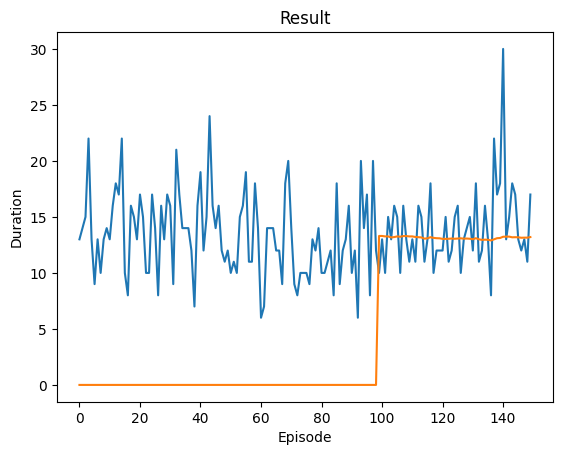

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [26]:
if torch.cuda.is_available():
    num_episodes = 150
else:
    num_episodes = 50

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, info = env.reset()
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, info = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = observation

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

Here is the diagram that illustrates the overall resulting data flow.

.. figure:: /_static/img/reinforcement_learning_diagram.jpg

Actions are chosen either randomly or based on a policy, getting the next
step sample from the gym environment. We record the results in the
replay memory and also run optimization step on every iteration.
Optimization picks a random batch from the replay memory to do training of the
new policy. The "older" target_net is also used in optimization to compute the
expected Q values. A soft update of its weights are performed at every step.




### Save memory data

In [33]:
# create API for saving and loading memory data
def saveMemoryData(memory, path):
    pass

In [34]:
def loadMemoryData(memory, path):
    pass

## Testing

### Test pipeline

Use trained model to help select optimal actions until finishing 1 trial, and compare a random action selector

In [27]:
# create actions for network input
df_actions = env.actions.copy()
df_actions.loc[:, 'drc'] = np.ones(len(df_actions)) * -1
actions = df_actions.to_numpy()

def select_test_action(state, model):
    global actions
    # select action according to policy
    with torch.no_grad():
        inputs = np.vstack((state, actions))
        inputs = torch.from_numpy(inputs)
        inputs = inputs.to(device, dtype=torch.float32)
        # select the action with minimum DRC output as optimum action
        action = model(inputs).min(0).indices.view(1, 1)
        return action.item()

In [28]:
# test loop
count = 0
# start trial
env.reset()
action = select_test_action(observation, policy_net)
observation, reward, terminated, truncated, info = env.step(action)
while not(terminated or truncated):
    print(f"iteration {count} action {action} DRC = {int(observation[-1, -1] * 1e6)}\n")
    # start next iteration
    count += 1
    action = select_test_action(observation, policy_net)
    observation, reward, terminated, truncated, info = env.step(action)
    
print(f"iteration {count} action {action} DRC = {int(observation[-1, -1] * 1e6)}\n")
env.close()

iteration 0 action 9 DRC = 393467

iteration 1 action 9 DRC = 72664

iteration 2 action 9 DRC = 23495

iteration 3 action 9 DRC = 15014

iteration 4 action 9 DRC = 1719

iteration 5 action 9 DRC = 1260

iteration 6 action 9 DRC = 1146

iteration 7 action 9 DRC = 458

iteration 8 action 9 DRC = 229

iteration 9 action 9 DRC = 114

iteration 10 action 9 DRC = 0



/tmp/ipykernel_15530/1370369620.py:133: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if int(self._curr_drc * self.maxdrc) == 0:
/tmp/ipykernel_15530/1370369620.py:136: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  drc = np.array(self.np_random.integers(0, int(self._curr_drc * self.maxdrc), size=1, dtype=int) / self.maxdrc)


## Deployment

Save model. Load model and run test case

### converting to torch script via tracing

In [29]:
# converting to Torch Script via annotation
scriptModule = torch.jit.script(policy_net)

TypeError: 
'numpy.int64' object in attribute 'Linear.in_features' is not a valid constant.
Valid constants are:
1. a nn.ModuleList
2. a value of type {bool, float, int, str, NoneType, torch.device, torch.layout, torch.dtype}
3. a list or tuple of (2)


In [30]:
# serialize model to a file
modelName = "./model/DQN_FC.pt"
scriptModule.save(modelName)

NameError: name 'scriptModule' is not defined

### verify C++ model output

In [31]:
# load model
loadModelName = modelName
model = torch.jit.load(loadModelName)
model.eval()

ValueError: The provided filename ./model/DQN_FC.pt does not exist

In [32]:
# test loop
count = 0
# start trial
env.reset()
action = select_test_action(observation, model)
observation, reward, terminated, truncated, info = env.step(action)
while not(terminated or truncated):
    print(f"iteration {count} action {action} DRC = {int(observation[-1, -1] * 1e6)}\n")
    # start next iteration
    count += 1
    action = select_test_action(observation, model)
    observation, reward, terminated, truncated, info = env.step(action)
    
print(f"iteration {count} action {action} DRC = {int(observation[-1, -1] * 1e6)}\n")
env.close()

NameError: name 'model' is not defined